<a href="https://colab.research.google.com/github/edponce/DoyleInvestigators/blob/master/Project1_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import os
import re
import copy
import pprint
import collections
import urllib.request
import urllib.parse
import numpy as np
import seaborn as sns  # 0.10.1 (0.11 fails in barplot)
import pandas
import matplotlib.pyplot as plt

###$\color{brown}{\rm Corpus~Selection}$

In [ ]:
CORPUS_URL = {
    'The Valley of Fear': "http://www.gutenberg.org/files/3289/3289.txt",
    'A Study in Scarlet': "http://www.gutenberg.org/files/244/244.txt",
    'The Sign of the Four': "http://www.gutenberg.org/files/2097/2097.txt",
    'The Hound of the Baskervilles': "http://www.gutenberg.org/files/2852/2852.txt",
    'The Adventures of Sherlock Holmes': 'https://www.gutenberg.org/files/1661/1661.txt',
}

###$\color{brown}{\rm Characters~and~Aliases}$

In [ ]:
CHARACTERS = {
    'The Valley of Fear': {
        'main': [
            ['Sherlock Holmes'],
            ['John Watson'],
            ['Alec MacDonald'],
            ['Fred Porlock'],
            ['John Douglas', 'Birdy Edwards', 'Mr. Douglas'],
            ['James Moriarty'],
            ['Cecil Barker'],
            ['Sergeant Wilson'],
            ['White Mason'],
            ['Mrs. Douglas'],
            ['Ted Baldwin'],
        ],
        'detectives': [
            ['Sherlock Holmes'],
            ['John Watson'],
            ['Alec MacDonald'],
            ['White Mason'],
        ],
        'perpetrators': [
            # NOTE: James Moriarty's organism?
            ['James Moriarty'],
        ],
    },
    'A Study in Scarlet': {
        'main': [
            ['Sherlock Holmes'],
            ['John Watson'],
            ['Inspector Gregson'],
            ['Inspector Lestrade'],
            ['Enoch Drebber'],
            ['Joseph Stangerson'],
            ['Jefferson Hope', 'cab', 'cabman'],
            ['John Ferrier'],
            ['Lucy'],
            ['Brigham Young'],
        ],
        'detectives': [
            ['Sherlock Holmes'],
            ['John Watson'],
            ['Inspector Gregson'],
            ['Inspector Lestrade'],
        ],
        'perpetrators': [
            ['Jefferson Hope', 'cab', 'cabman'],
            ['Enoch Drebber'],
            ['Joseph Stangerson'],
        ],
    },
    'The Sign of the Four': {
        'main': [
            ['Sherlock Holmes'],
            ['John Watson'],
            ['Mary Morstan'],
            ['Arthur Morstan'],
            ['Major John Sholto'],
            ['Thaddeus Sholto'],
            ['Bartholomew Sholto'],
        ],
        'detectives': [
            ['Sherlock Holmes'],
            ['John Watson'],
        ],
        'perpetrators': [
            ['Johnathan Small'],
            ['Tonga'],
        ],
    },
    'The Hound of the Baskervilles': {
        'main': [
            ['Sherlock Holmes'],
            ['John Watson'],
            ['James Mortimer'],
            ['Charles Baskerville'],
            ['Henry Baskerville'],
            ['Jack Stapleton'],
            ['Beryl Stapleton'],
            ['Barrymore'],
            ['Selden'],
        ],
        'detectives': [
            ['Sherlock Holmes'],
            ['John Watson'],
        ],
        'perpetrators': [
            ['Jack Stapleton'],
        ],
    },
    'The Boscombe Valley Mystery': {
        'main': [
            ['Sherlock Holmes'],
            ['John Watson'],
            ['Inspector Lestrade'],
            ['James McCarthy'],
            ['John Turner'],
            ['Alice Turner'],
        ],
        'detectives': [
            ['Sherlock Holmes'],
            ['John Watson'],
        ],
        'perpetrators': [
            ['John Turner'],
        ],
    },
}

###$\color{brown}{\rm Read/Load~Corpus}$
Read a corpus from web page or file to start processing.

In [ ]:
def get_corpus_from_url(url):
    with urllib.request.urlopen(url) as fd:
        text = fd.read()
        try:
            return text.decode('utf-8')
        except UnicodeDecodeError:
            return text.decode('iso-8859-1')


def get_corpus_from_file(file):
    with open(file) as fd:
        return fd.read()


def get_corpus(key):
    def validate_url(url):
        parsed_url = urllib.parse.urlparse(url)
        return all([parsed_url.scheme, parsed_url.netloc, parsed_url.path])

    # Check if a filename was provided
    if os.path.isfile(key):
        return get_corpus_from_file(key)
    else:
        if key in CORPUS_URL:
            file = os.path.basename(CORPUS_URL[key])
            if os.path.isfile(file):
                return get_corpus_from_file(file)

    # Check if a URL was provided
    if validate_url(key):
        return get_corpus_from_url(key)
    else:
        if key in CORPUS_URL:
            url = CORPUS_URL[key]
            if validate_url(url):
                return get_corpus_from_url(url)

    raise Exception(f"corpus '{key}' not found")

###$\color{brown}{\rm Regexes~for~Headings}$
Functions to get spans of headings:
* Gutenberg tags
* Named headings - parts, chapters, adventures
* Numbered headings
* Epilogue

In [ ]:
def get_newline_index(text):
    """Find the index of the first newline in the text.
    This is used to skip/correct one newline at beginning of headings.
    """
    match = re.match(r'[ \t\r]*\n', text)
    return match.end() if match else 0


def get_gutenberg_start_heading(text, span=None):
    """Find Gutenberg's start tag (and producer, if available).

    Notes:
        * re.match() searches at the beginning of strings, but there are
          certain character combinations that are not considered strings,
          and thus need to use re.search(), even if it is at the beginning
          of line. An example are the asterisks in the Gutenberg START
          tag.
    """
    if not span:
        span = (0, len(text))

    match = re.search(
        r'(^\s*|(\s*\n){2,})'  # pre-whitespace, no indentation
        r'\*{3}\s*'  # 3 asterisks
        r'start[^\r\n]+'  # tag text
        r'\s*\*{3}'  # 3 asterisks
        r'(\s*\nproduced by.+)?'  # producer line
        r'(\s*\n){2,}',  # post-whitespace
        text[span[0]:span[1]],
    )

    if match:
        span = match.span()
        offs = get_newline_index(text[span[0]:span[1]])
        return span[0] + offs, span[1]


def get_gutenberg_end_heading(text, span=None):
    """Find Gutenberg's end tag (and transcriber's notes, if available).

    Notes:
        * Duplicate/similar Gutenberg end tags.
        * Use a newline before transcriber note to prevent matching similar
          (but indented) notes at beginning of text.
        * Use DOTALL flag to match transcriber's notes across multiple lines.
          But be wary that using DOTALL prevents the use of '.+' for other
          cases, so use '[^\r\n]' instead.
    """
    if not span:
        span = (0, len(text))

    match = re.search(
        r'('
        r'(\s*\n){2,}'  # pre-whitespace, no indentation
        r'(original transcriber.+\s*\n)?'  # transcriber notes
        r'end[^\r\n]+'  # duplicate/similar tag text
        r')?'
        r'\s*\n'  # pre-whitespace, no indentation
        r'\*{3}\s*'  # 3 asterisks
        r"end[^\r\n]+"  # tag text
        r'\s*\*{3}'  # 3 asterisks
        r'(\s*\n){2,}',  # post-whitespace
        text[span[0]:span[1]],
        flags=re.DOTALL,
    )

    if match:
        span = match.span()
        offs = get_newline_index(text[span[0]:span[1]])
        return span[0] + offs, span[1]


def get_named_headings(text, name, span=None):
    """Find named headings with title."""
    if not span:
        span = (0, len(text))

    spans = [
        (match.start() + span[0], match.end() + span[0])
        for match in re.finditer(
            r'(^(\s*)|(\s*\n){2,})'  # pre-whitespace, no indentation
            r'('
            fr'{name}[ \t]+(\d+|[ivxlcd]+)'  # label with Arabic/Roman number
            r'(-+|\.)?'  # label-title delimiter
            r'((\s*\n){2})?'  # whitespace for titles two line apart
            r'.*(\r?\n.*)?'  # title (muti-line support)
            r'|'  # cases: name # \s* label, # name/label
            r'(\d+|[ivxlcd]+)'  # label with Arabic or Roman numbering
            r'(-+|\.)?'  # label-title delimiter
            fr'[ \t]+.*{name}.*'  # label with name
            r')'
            r'(\s*\n){2,}',  # post-whitespace
            text[span[0]:span[1]],
        )
    ]

    _spans = []
    for _span in spans:
        offs = get_newline_index(text[_span[0]:_span[1]])
        _spans.append((_span[0] + offs, _span[1]))
    return _spans


def get_numbered_headings(text, span=None):
    """Find numbered headings with no title."""
    if not span:
        span = (0, len(text))

    spans = [
        (match.start() + span[0], match.end() + span[0])
        for match in re.finditer(
            r'(^\s*|(\s*\n){2,})'  # pre-whitespace, no indentation
            fr'(\d+|[ivxlcd]+)'  # label with Arabic or Roman numbering
            r'(-+|\.)'  # label-title delimiter
            r'(\s*\n){2,}',  # post-whitespace
            text[span[0]:span[1]]
        )
    ]

    _spans = []
    for _span in spans:
        offs = get_newline_index(text[_span[0]:_span[1]])
        _spans.append((_span[0] + offs, _span[1]))
    return _spans


def get_epilogue_heading(text, span=None):
    if not span:
        span = (0, len(text))

    match = re.search(
        r'(^\s*|(\s*\n){2,})'  # pre-whitespace, no indentation
        r'epilogue'  # tag text
        r'(\s*\n){2,}',  # post-whitespace
        text[span[0]:span[1]]
    )

    if match:
        span = match.span()
        offs = get_newline_index(text[span[0]:span[1]])
        return span[0] + offs, span[1]

###$\color{brown}{\rm Regions~of~Interest~(ROI)}$
Functions to get spans of text between headings.

In [ ]:
def get_headings_map(
    text,
    headings=['part', 'chapter', 'adventure', 'epilogue', 'numbered'],
):
    """Create a list of all heading spans, guarantees at least one set
    of bounding spans.

    Args:
        headings (str, List[str]): Heading names to search for.
    """
    if not isinstance(headings, (list, tuple, set)):
        _headings = [headings]
    else:
        _headings = copy.deepcopy(headings)

    headings_map = {}
    _headings_map = {}

    # Always available heading, all text
    text_heading = '_text_'

    # Ensure there is always a begin "span"
    start_span = get_gutenberg_start_heading(text)
    if not start_span:
        start_span = 0, 0

    # Ensure there is always an end "span"
    end_span = get_gutenberg_end_heading(text)
    if not end_span:
        end_span = len(text), len(text)
    headings_map[text_heading] = [start_span, end_span]
    if text_heading in _headings:
        _headings.remove(text_heading)

    # Optional
    span = get_epilogue_heading(text)
    if span:
        heading = 'epilogue'
        _headings_map[heading] = [span, headings_map[text_heading][1]]
        if heading in _headings:
            headings_map[heading] = _headings_map[heading]
            _headings.remove(heading)

    # Optional
    spans = get_numbered_headings(text)
    if spans:
        heading = 'numbered'
        _headings_map[heading] = [*spans, headings_map[text_heading][1]]
        if heading in _headings:
            headings_map[heading] = _headings_map[heading]
            _headings.remove(heading)

    # Optional
    for heading in _headings:
        spans = get_named_headings(text, heading)
        if spans:
            headings_map[heading] = spans
            if 'epilogue' in _headings_map:
                headings_map[heading].append(_headings_map['epilogue'][0])
            else:
                headings_map[heading].append(headings_map[text_heading][1])
    return headings_map


def select_rois_spans(spans, n=None):
    if n is None:
        _spans = [
            (spans[i][1], spans[i + 1][0])
            for i in range(len(spans) - 1)
        ]
    else:
        _spans = [
            (spans[i - 1][1], spans[i][0])
            for i in ([n] if isinstance(n, int) else n)
            if i >= 1 and i < (len(spans))
        ]
    return _spans


def get_rois(text, name=None, *, n=None, headings_map=None):
    """Get span bounding a ROI.

    Args:
        name (str): ROI

        n (int, Iterable[int]): Number of ROI, [1,N]
    """
    if not headings_map:
        headings_map = get_headings_map(text)

    # Always available heading, all text
    text_heading = '_text_'

    rois = []
    if not name:
        rois = [(
            headings_map[text_heading][0][1],
            headings_map[text_heading][1][0],
        )]
    elif name in headings_map:
        rois = select_rois_spans(headings_map[name], n)

    # If necessary, skip last inner heading
    _rois = []
    for roi in rois:
        value = roi[1]
        for spans in headings_map.values():
            for span in spans:
                if roi[1] > span[0] and roi[1] <= span[1]:
                    value = span[0]
        _rois.append((roi[0], value))
    return _rois


def get_roi(text, name, span=None, *, n=None):
    if not span:
        spans = get_rois(text, name, n=n)
    else:
        spans = [
            (_span[0] + span[0], _span[1] + span[0])
            for _span in get_rois(text[span[0]:span[1]], name, n=n)
        ]
    return spans


def get_unique_spans(spans):
    """Given a list of spans, remove fully embedded spans."""
    unique_spans = spans
    for span in spans:
        for _span in spans:
            if (
                span != _span and
                (span[0] >= _span[0] and span[1] <= _span[1])
            ):
                unique_spans.remove(span)
    return unique_spans


def get_text_from_span(text, span=None):
    if not span:
        span = (0, len(text))
    elif isinstance(span[0], int):
        span = [span]

    roi = ''
    for _span in span:
        roi += text[_span[0]:_span[1]]
    return roi


def get_text(text, span=None, *, n=None):
    return get_rois(text)


def get_parts(text, span=None, *, n=None):
    return get_roi(text, 'part', span, n=n)


def get_chapters(text, span=None, *, n=None):
    return get_roi(text, 'chapter', span, n=n)


def get_adventures(text, span=None, *, n=None):
    return get_roi(text, 'adventure', span, n=n)


def get_numbered_sections(text, span=None, *, n=None):
    return get_roi(text, 'numbered', span, n=n)


def get_epilogue(text, span=None):
    return get_roi(text, 'epilogue', span)

###$\color{brown}{\rm Tokenization}$
Regexes to get text decomposition:
* Paragraphs
* Sentences
* Tokens

In [ ]:
def tokenize(text, span=None, regex=r'\w', *, use_remaining=False):
    def _get_tokens(text):
        return [
            match.span()
            for match in re.finditer(regex, text)
        ]

    if not span:
        span = (0, len(text))

    # Get tokens from text
    # Add base offset to tokens' spans
    tokens = [
        (tok_span[0] + span[0], tok_span[1] + span[0])
        for tok_span in _get_tokens(text[span[0]:span[1]])
    ]

    if use_remaining:
        if tokens:
            # Extend last token to end of text
            tokens[-1] = tokens[-1][0], span[1]
        else:
            # Consider all text as the token
            tokens = [span]

    return tokens


def select_spans(spans, n=None):
    if n is None:
        _spans = spans
    else:
        _spans = [
            spans[i - 1]
            for i in ([n] if isinstance(n, int) else n)
            if i >= 1 and i <= (len(spans))
        ]
    return _spans


def get_paragraphs(text, span=None, *, n=None):
    spans = tokenize(
        text,
        span,
        r'('
        r'([^\r\n]+\r?\n)+'  # (regular text with newline)+
        r'('
        r'(\r?\n)+'  # (newline)+
        r'[^a-zA-Z]'  # non-alpha character: quote, number, etc.
        r')?'  # handles case of multiple newlines but still same paragraph
        r')+',  # (full regex)+
        use_remaining=True,
    )
    return select_spans(spans, n)


def get_sentences(text, span=None, *, n=None):
    spans = tokenize(
        text,
        span,
        r'(([^\.\r\n;M!]+\n?)+(.")?(M[rR][sS]?\.\s)?(M)?)+'
        r'|'
        r'M[rR][sS]?\.\s([^\.;M!]+(.")?(M[rR][sS]?\.\s)?(M)?)+',
    )
    return select_spans(spans, n)


def get_tokens(text, span=None, *, n=None):
    spans = tokenize(
        text,
        span,
        r'\w+'  # compound alphanumeric words
        r'('
        r"'\w+"  # contractions
        r'|(-\w+)+'  # tokens with inlined dashes
        r')'
        r'|\w+'  # single alphanumeric words
        r'|\$?-?\d+(,\d+)*(\.\d+)?',  # numbers, decimals, monetary
    )
    return select_spans(spans, n)

###$\color{brown}{\rm Frequency~Count}$
For vocabulary and keywords/entities

In [ ]:
def get_keywords_map(text, span=None, keywords=[], *, spans_map=None):
    if spans_map is None:
        spans_map = collections.defaultdict(list)

    # NOTE: Allow cases where token is a prefix/compound of a longer token
    for kw in keywords:
        spans_map[kw].extend(tokenize(
            text,
            span,
            fr'(?<![a-zA-Z0-9]){kw}',
        ))
    return spans_map


def generate_frequency_map(spans_map, *, threshold=None):
    freq = collections.defaultdict(int)
    for k, v in spans_map.items():
        if threshold is None or len(v) >= threshold:
            freq[k] = len(v)
    return freq


def get_vocabulary(text, span=None, *, vocab=None):
    return (
        list(vocab) if vocab else []
    ) + [
        get_text_from_span(text, token_span)
        for token_span in get_tokens(text, span)
    ]


def get_vocabulary_map(text, span=None, *, spans_map=None):
    if spans_map is None:
        spans_map = collections.defaultdict(list)

    for token_span in get_tokens(text, span):
        token = get_text_from_span(text, token_span)
        spans_map[token].append(token_span)
    return spans_map

###$\color{brown}{\rm Visualization}$

In [ ]:
def visualize_co_occurrence(data, keywords_rows, closeness_words_columns):
    # Create a dataframe from the provided data
    df = pandas.DataFrame(
        data,
        index=keywords_rows,
        columns=closeness_words_columns,
    )

    # Set plot size according to the number of cols and rows
    plt.figure(figsize=(len(columns_example), len(rows_example)))

    # Set color of heatmap
    heatmap = sns.heatmap(df, cmap="YlGnBu", annot=True, linewidths=.5)

    # Rotate text
    loc_x, labels_x = plt.xticks()
    loc_y, labels_y = plt.yticks()
    heatmap.set_xticklabels(labels_x, rotation=58)
    heatmap.set_yticklabels(labels_y, rotation=0)
    plt.show()

Example of co-occurrence

In [ ]:
# Example of expected format of data that the method needs
rows_example = ["murder", "guilty","suspect","assassin"]
columns_example = ["Holmes", "Moriarty","Banks","Charles","Jack","Tom","Jim","Jane","Jackson"]
data_example = [[4,5,0,0,2,1,3,2,0],[0,0,2,1,4,3,6,1,0],[5,0,0,1,3,2,4,5,1],[0,0,1,0,0,0,5,2,0]]

# Plot
visualize_co_occurrence(data_example,rows_example,columns_example)

In [22]:
def barplot(data, labels, xlabel='Word', ylabel='Frequency'):
    # Prepare the data to pandas
    data_ = [labels, data]
    data_ = np.asarray(data_).transpose()

    # Create a dataframe from the provided data
    df = pandas.DataFrame(data_, columns=[xlabel, ylabel])
    sns.barplot(x=xlabel, y=ylabel, data=df, palette="Blues_d")
    plt.show()

Example of word count histogram

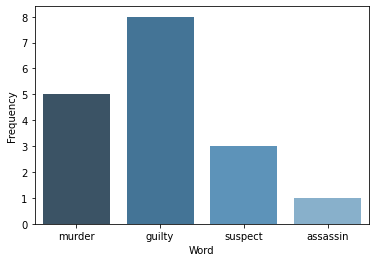

In [23]:
# Example of expected format of data that the method needs
labels_example = ["murder", "guilty","suspect","assassin"]
data_example = [5,8,3,1]

# Plot
barplot(data_example,labels_example)

###$\color{brown}{\rm Drivers}$

# Negative words frequency/histogram

In [26]:
def get_negative_words(negative_words):
    """
    Get list of negative words
    """
    regex_result = [negative_words[match.span()[0]:match.span()[1]] for match in re.finditer(r'(?<=\n)[a-zA-Z]+(?=\n)', negative_words)]
    return regex_result

def get_top_negative_words(corpus, negative_list, top):
    """
    Get top list of negative words
    """
    frequency_list = []
    for word in negative_list:
        result_list = [match.span() for match in re.finditer(fr'(?<![a-zA-Z0-9]){word}(?![a-z])', corpus)]
        frequency_list.append(len(result_list))
    
    # Sort results
    temp_list = np.asarray(list(zip(negative_list,frequency_list)), dtype = [('word', np.unicode_, 16), ('frequency', int)] )
    sorted_list = np.sort(temp_list, order='frequency', kind="quicksort")
    sorted_list = sorted_list[::-1]

    return sorted_list[:top]


# Get negative words
url = "https://raw.githubusercontent.com/edponce/DoyleInvestigators/develop/negative-words.txt"
negative_words = get_corpus_from_url(url)
result_negative = get_negative_words(negative_words)

# Get corpus (use all text between Gutenberg tags)
corpus = get_corpus('The Valley of Fear')
corpus_l = corpus.lower()
text = get_text_from_span(corpus_l, get_text(corpus_l)[0])

# Get count
results = get_top_negative_words(text, result_negative, top=20)
print(results)

[('fear', 42) ('murder', 39) ('crime', 36) ('dead', 31) ('danger', 30)
 ('doubt', 27) ('dark', 24) ('strange', 22) ('hard', 22) ('bad', 19)
 ('trouble', 17) ('terrible', 15) ('cold', 15) ('struck', 14)
 ('stranger', 14) ('death', 14) ('criminal', 14) ('worse', 13)
 ('dumb', 13) ('warning', 12)]


# Example of negative keyword count

In [ ]:
corpus = get_corpus('The Valley of Fear')
text = corpus.lower()

# Get region of interest (ROI)
roi_span = get_text(text)  # all text
print(roi_span)

# Search keywords
keywords = ['dead', 'death', 'murder', 'crime', 'hurt', 'blood', 'treasure',
            'suffer', 'guilty', 'assassin', 'suspect', 'pain']
keyword_spans = get_keywords_map(text, roi_span[0], keywords)

In [ ]:
# Generate frequency table
keyword_freq = generate_frequency_map(keyword_spans, threshold=5)
print(keyword_freq)

# Plot
labels = list(keyword_freq.keys())
data = list(keyword_freq.values())
print(labels)
print(data)
barplot(data, labels)

# Story structure

In [ ]:
def count_text_structure(text, span=None, structure=None):
    if structure is None:
        structure = collections.defaultdict(int)

    for par_span in get_paragraphs(text, span):
        structure['Paragraphs'] += 1
        for sent_span in get_sentences(text, par_span):
            structure['Sentences'] += 1
            for tok_span in get_tokens(text, sent_span):
                structure['Words'] += 1


structures = {}

story = 'The Valley of Fear'
corpus = get_corpus(story)
text = corpus.lower()
structure = collections.defaultdict(int)
for part_span in get_parts(text):
    structure['Parts'] += 1
    for chp_span in get_chapters(text, part_span):
        structure['Chapters'] += 1
        count_text_structure(text, chp_span, structure)
structure['Epilogue'] = 1
span = get_text(text)[0]
structure['Characters'] = span[1] - span[0]
count_text_structure(text, get_epilogue(text)[0], structure)
structures[story] = structure

story = 'A Study in Scarlet'
corpus = get_corpus(story)
text = corpus.lower()
structure = collections.defaultdict(int)
for part_span in get_parts(text):
    structure['Parts'] += 1
    for chp_span in get_chapters(text, part_span):
        structure['Chapters'] += 1
        count_text_structure(text, chp_span, structure)
span = get_text(text)[0]
structure['Characters'] = span[1] - span[0]
structures[story] = structure

story = 'The Sign of the Four'
corpus = get_corpus(story)
text = corpus.lower()
structure = collections.defaultdict(int)
for chp_span in get_chapters(text):
    structure['Chapters'] += 1
    count_text_structure(text, chp_span, structure)
span = get_text(text)[0]
structure['Characters'] = span[1] - span[0]
structures[story] = structure

story = 'The Hound of the Baskervilles'
corpus = get_corpus(story)
text = corpus.lower()
structure = collections.defaultdict(int)
for chp_span in get_chapters(text):
    structure['Chapters'] += 1
    count_text_structure(text, chp_span, structure)
span = get_text(text)[0]
structure['Characters'] = span[1] - span[0]
structures[story] = structure

corpus = get_corpus('The Adventures of Sherlock Holmes')
text = corpus.lower()
structure = collections.defaultdict(int)
adv_span = get_adventures(text, n=4)[0]
count_text_structure(text, adv_span, structure)
structure['Characters'] = adv_span[1] - adv_span[0]
structures['The Boscombe Valley Mystery'] = structure

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(structures)

# Count character entities

In [ ]:
def get_entity_variants(entity, *, invalid_entities=[]):
    """Given a string with whitespace, return all combinations."""
    variants = []
    entity_parts = entity.split()
    for i in range(len(entity_parts)):
        for j in range(i+1, len(entity_parts)+1):
            variant = ' '.join(entity_parts[i:j])
            if variant not in invalid_entities:
                variants.append(variant)
    return variants


def search_entity(entities, text, span=None, *, invalid_entities=[]):
    if not isinstance(entities, (list, tuple, set)):
        entities = [entities]

    if span is None:
        span = (0, len(text))

    entities_map = collections.defaultdict(list)
    for entity in entities:
        entity_variants = get_entity_variants(
            entity,
            invalid_entities=invalid_entities,
        )
        entity_map = get_keywords_map(text, span, entity_variants)
        if entity_map:
            for spans in entity_map.values():
                entities_map[entity].extend(spans)

    _entities_map = collections.defaultdict(list)
    for entity, spans in entities_map.items():
        _entities_map[entity] = get_unique_spans(spans)
    return _entities_map


def combine_characters(characters_map):
    characters = set()
    for character in characters_map:
        for name in character:
            characters.add(name)
    return characters


def convert_spans_to_counts_map(spans_map):
    return {
        key:len(spans)
        for key, spans in spans_map.items()
    }


invalid_entities = ['Mr.', 'Mrs.', 'Inspector', 'Major']

stories_spans = {}
stories_counts = {}
for story in CORPUS_URL.keys():
    stories_spans[story] = {}
    stories_counts[story] = {}
    corpus = get_corpus(story)
    text = corpus.lower()

    # Special case; story in compilation
    if story == 'The Adventures of Sherlock Holmes':
        story = 'The Boscombe Valley Mystery'

    detectives = combine_characters(CHARACTERS[story]['detectives'])
    for n, chp_span in enumerate(get_chapters(text), start=1):
        stories_spans[story][n] = search_entity(detectives, corpus, chp_span, invalid_entities=invalid_entities)
        stories_counts[story][n] = convert_spans_to_counts_map(stories_spans[story][n])

print(stories_spans)
print(stories_counts)

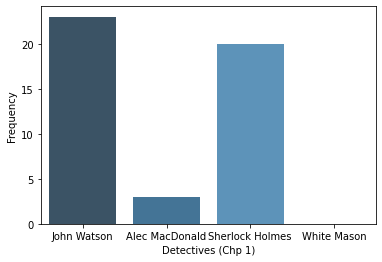

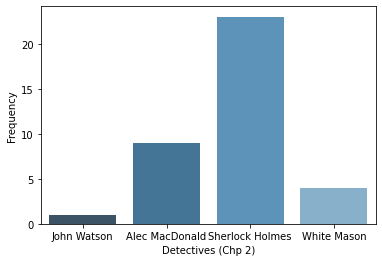

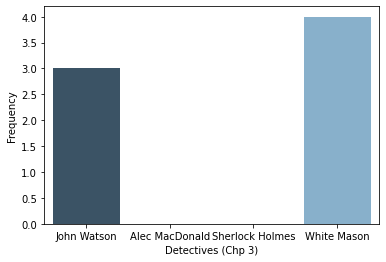

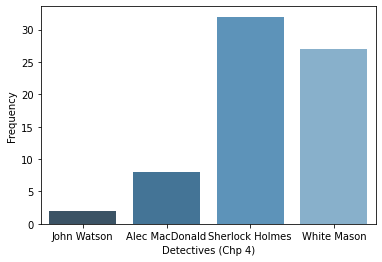

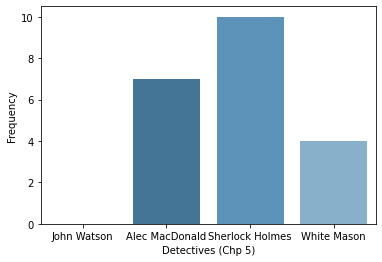

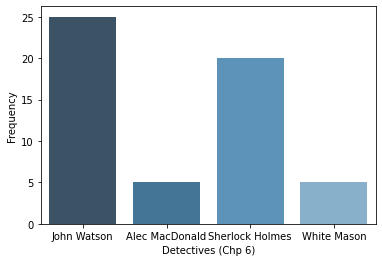

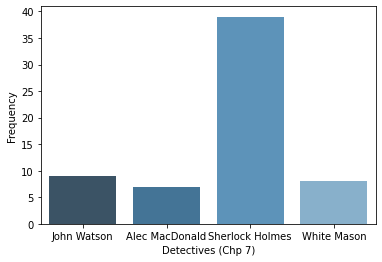

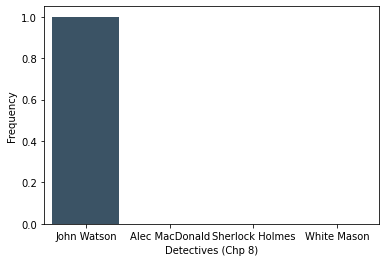

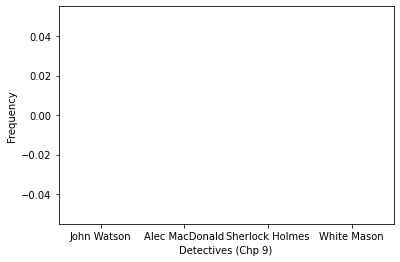

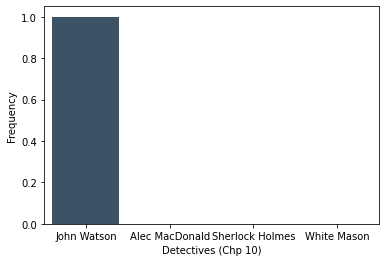

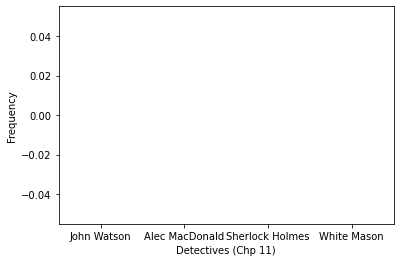

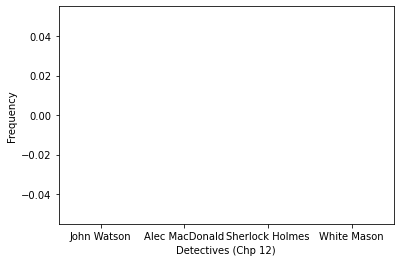

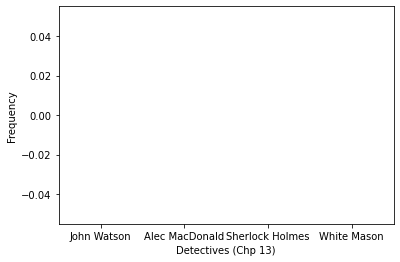

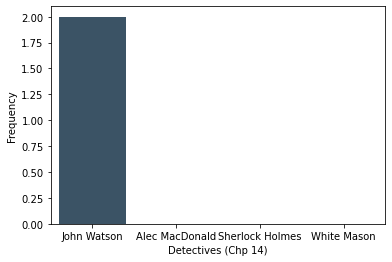

In [25]:
# Plot stories counts
# for story in CORPUS_URL.keys():
for story in ['The Valley of Fear']:
    # Special case: story in compilation
    if story == 'The Adventures of Sherlock Holmes':
        story = 'The Boscombe Valley Mystery'
    for chp, freq in stories_counts[story].items():
        labels = list(freq.keys())
        data = list(freq.values())
        barplot(data, labels, xlabel=f'Detectives (Chp {chp})')